# Segmentation of Indian Traffic

In [2]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
# from tqdm.notebook import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import json
import imgaug.augmenters as iaa
import datetime

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [2]:
def return_file_names_df(root_dir):
    root_dir = 'data'
    img_path = root_dir+"/images"
    mask_path = root_dir+'/mask'
    file_names_images = list()
    file_names_masks =list()
    for scene in os.listdir(img_path):
        mask_dir = [i for i in os.listdir(mask_path+'/'+scene)]
        for i in os.listdir(img_path+'/'+scene):
            to_find = i.split('_')[0]
            mask = list(filter(lambda x: to_find in x, mask_dir))[0]
            file_names_images.append(img_path+'/'+scene+'/'+i)
            file_names_masks.append(mask_path+'/'+scene+'/'+mask)

    data_df = pd.DataFrame(list(zip(file_names_images, file_names_masks)), 
               columns =['images', 'json']) 
    return data_df

In [3]:
data_df = return_file_names_df('data')
data_df.head()

,images,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


In [6]:
data_df.shape

(4007, 2)

#### Compute the unique labels

In [7]:
import json
def return_unique_labels(data_df):
    unique_labels = set()
    for mask in data_df['json']:
        f = open(mask,) 
        data = json.load(f)
        for i in data['objects']:
            unique_labels.add(i['label'])
        f.close()
    return unique_labels

In [8]:
unique_labels = return_unique_labels(data_df)
len(unique_labels)

40

In [9]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':180, 'ground':190,'rectification border':200,\
                   'train':210}

## 3. Extracting the polygons from the json files

In [11]:
def get_poly(mask):
    f = open(mask,) 
    data = json.load(f)
    labels = []
    for i in data['objects']:
        labels.append(i['label'])
    vertexList = []
    for i in data['objects']:
        vertexList.append([(k[0],k[1]) for k in i['polygon']])
   
    # width of the image
    w = data['imgWidth']
    # height of the image
    h = data['imgHeight']
    f.close()
    return w, h, labels, vertexList

In [12]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

In [29]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath
from pathlib import Path

In [14]:
def compute_masks(data_df):
    new_df = data_df.copy()
    masks = []
    for i in data_df['json']:
        w, h, label, vertexlist = get_poly(i)
        img = Image.new("RGB", (w, h))
        img1 = ImageDraw.Draw(img)
        for j in range(len(vertexlist)):
            try:
                img1.polygon(vertexlist[j], fill = label_clr[label[j]])
            except TypeError:
                continue
        img=np.array(img)

        path = i.split('/')
        Path(path[0]+'/output/'+path[2]).mkdir(parents=True, exist_ok=True)
        path = path[0]+'/output/'+path[2]+'/'+path[-1].split('.')[0]+'.png'
        masks.append(path)
        im = Image.fromarray(img[:,:,0])
        im.save(path,'PNG')

    new_df['mask'] = masks
    return new_df

In [15]:
data_df = compute_masks(data_df)
data_df.head()

,images,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [17]:
def resize_images(dir):
    for item in dir:
        if os.path.isfile(item):
            im = Image.open(item)
            imResize = im.resize((256,256), Image.ANTIALIAS)
            imResize.save(item, 'JPEG', quality=90)
resize_images(data_df['images'])
resize_images(data_df['mask'])

In [3]:
data_df = pd.read_csv('preprocessed_data.csv')
data_df.head()

,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [4]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

### Task 2.1: Dice loss

### Task 2.2: Training Unet

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_df['image'],data_df['mask'], test_size=0.2, random_state=42)

In [6]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [7]:
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [8]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
class Dataset:
    def __init__(self, image_ids, mask_ids, augment=False):
        
        self.ids = image_ids
        self.mask_ids = mask_ids
        # the paths of images
        self.images_fps   = [image_id for image_id in self.ids]
        # the paths of segmentation images
        self.masks_fps    = [image_id for image_id in self.mask_ids]
        self.augment = augment
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image,(256,256),interpolation=cv2.INTER_AREA)
        
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask,(256,256),interpolation=cv2.INTER_AREA)
        #normalizing mask
        mask = mask//10

        image_masks = [(mask == v) for v in np.arange(0,21,1)]
        image_mask = np.stack(image_masks, axis=-1).astype('float')

        if self.augment:
            a = np.random.uniform()
            if a<0.2:
                image = aug2.augment_image(image)
                image_mask = aug2.augment_image(image_mask)
            elif a<0.4:
                image = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            elif a<0.6:
                image = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            elif a<0.8:
                image = aug5.augment_image(image)
                image_mask = image_mask
            else:
                image = aug6.augment_image(image)
                image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [9]:
train_dataset = Dataset(X_train,y_train, augment=False)
train_dataloader = Dataloder(train_dataset, batch_size=2, shuffle=True)

test_dataset = Dataset(X_test,y_test)
test_dataloader = Dataloder(test_dataset, batch_size=2, shuffle=False)

In [10]:
X,Y = test_dataloader[0]
X.shape

(2, 256, 256, 3)

In [58]:
optim = keras.optimizers.RMSprop(lr=0.00001)

focal_loss = sm.losses.cce_dice_loss
model = Unet('resnet34',classes=21, activation='softmax',input_shape=(256,256,3),encoder_weights='imagenet')

model.compile(optim, focal_loss, metrics=[iou_score])

AttributeError: module 'tensorflow.python.framework.ops' has no attribute '_TensorLike'

In [25]:
model.load_weights('unet_2.h5')

In [26]:
# this was trained with a batch size of 8 on 256*256 images
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=500,\
                              validation_data=test_dataloader)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 400 steps, validate for 100 steps
Epoch 1/500
400/400 [==============================] - 159s 397ms/step - loss: 0.5049 - iou_score: 0.4189 - val_loss: 0.5745 - val_iou_score: 0.3667
Epoch 2/500
400/400 [==============================] - 151s 378ms/step - loss: 0.4972 - iou_score: 0.4241 - val_loss: 0.5741 - val_iou_score: 0.3662
Epoch 3/500
400/400 [==============================] - 151s 378ms/step - loss: 0.4925 - iou_score: 0.4275 - val_loss: 0.5737 - val_iou_score: 0.3661
Epoch 4/500
400/400 [==============================] - 151s 379ms/step - loss: 0.4889 - iou_score: 0.4301 - val_loss: 0.5736 - val_iou_score: 0.3661
Epoch 5/500
400/400 [==============================] - 152s 380ms/step - loss: 0.4858 - iou_score: 0.4325 - val_loss: 0.5737 - val_iou_score: 0.3659
Epoch 6/500
400/400 [==============================] - 151s 378ms/step - loss: 0.4831 - iou_score: 0.4346 - val_loss: 0.5737 - val_iou_score: 0.3658
Epoch 7/500


400/400 [==============================] - 152s 380ms/step - loss: 0.4380 - iou_score: 0.4754 - val_loss: 0.5874 - val_iou_score: 0.3595
Epoch 109/500
400/400 [==============================] - 152s 379ms/step - loss: 0.4378 - iou_score: 0.4756 - val_loss: 0.5879 - val_iou_score: 0.3594
Epoch 110/500
400/400 [==============================] - 154s 385ms/step - loss: 0.4377 - iou_score: 0.4758 - val_loss: 0.5878 - val_iou_score: 0.3595
Epoch 111/500
400/400 [==============================] - 154s 386ms/step - loss: 0.4377 - iou_score: 0.4757 - val_loss: 0.5878 - val_iou_score: 0.3593
Epoch 112/500
400/400 [==============================] - 154s 386ms/step - loss: 0.4374 - iou_score: 0.4760 - val_loss: 0.5880 - val_iou_score: 0.3593
Epoch 113/500
400/400 [==============================] - 153s 383ms/step - loss: 0.4374 - iou_score: 0.4761 - val_loss: 0.5881 - val_iou_score: 0.3593
Epoch 114/500
400/400 [==============================] - 154s 385ms/step - loss: 0.4370 - iou_score: 0.4764 

400/400 [==============================] - 150s 376ms/step - loss: 0.4248 - iou_score: 0.4892 - val_loss: 0.5968 - val_iou_score: 0.3555
Epoch 217/500
400/400 [==============================] - 151s 378ms/step - loss: 0.4247 - iou_score: 0.4893 - val_loss: 0.5968 - val_iou_score: 0.3553
Epoch 218/500
400/400 [==============================] - 152s 380ms/step - loss: 0.4246 - iou_score: 0.4894 - val_loss: 0.5971 - val_iou_score: 0.3552
Epoch 219/500
400/400 [==============================] - 153s 384ms/step - loss: 0.4246 - iou_score: 0.4895 - val_loss: 0.5971 - val_iou_score: 0.3553
Epoch 220/500
400/400 [==============================] - 153s 383ms/step - loss: 0.4244 - iou_score: 0.4896 - val_loss: 0.5972 - val_iou_score: 0.3552
Epoch 221/500
400/400 [==============================] - 151s 378ms/step - loss: 0.4244 - iou_score: 0.4897 - val_loss: 0.5974 - val_iou_score: 0.3552
Epoch 222/500
400/400 [==============================] - 152s 379ms/step - loss: 0.4242 - iou_score: 0.4899 

400/400 [==============================] - 155s 386ms/step - loss: 0.4162 - iou_score: 0.4986 - val_loss: 0.6042 - val_iou_score: 0.3521
Epoch 325/500
400/400 [==============================] - 154s 386ms/step - loss: 0.4161 - iou_score: 0.4988 - val_loss: 0.6041 - val_iou_score: 0.3521
Epoch 326/500
400/400 [==============================] - 154s 386ms/step - loss: 0.4161 - iou_score: 0.4987 - val_loss: 0.6045 - val_iou_score: 0.3519
Epoch 327/500
400/400 [==============================] - 155s 387ms/step - loss: 0.4158 - iou_score: 0.4991 - val_loss: 0.6043 - val_iou_score: 0.3521
Epoch 328/500
400/400 [==============================] - 155s 387ms/step - loss: 0.4159 - iou_score: 0.4990 - val_loss: 0.6045 - val_iou_score: 0.3519
Epoch 329/500
400/400 [==============================] - 154s 386ms/step - loss: 0.4158 - iou_score: 0.4992 - val_loss: 0.6044 - val_iou_score: 0.3518
Epoch 330/500
400/400 [==============================] - 155s 387ms/step - loss: 0.4152 - iou_score: 0.4999 

400/400 [==============================] - 152s 379ms/step - loss: 0.3739 - iou_score: 0.5420 - val_loss: 0.5873 - val_iou_score: 0.3720
Epoch 433/500
400/400 [==============================] - 152s 380ms/step - loss: 0.3739 - iou_score: 0.5419 - val_loss: 0.5883 - val_iou_score: 0.3711
Epoch 434/500
400/400 [==============================] - 151s 378ms/step - loss: 0.3738 - iou_score: 0.5421 - val_loss: 0.5887 - val_iou_score: 0.3707
Epoch 435/500
400/400 [==============================] - 154s 384ms/step - loss: 0.3734 - iou_score: 0.5424 - val_loss: 0.5905 - val_iou_score: 0.3691
Epoch 436/500
400/400 [==============================] - 153s 383ms/step - loss: 0.3737 - iou_score: 0.5422 - val_loss: 0.5884 - val_iou_score: 0.3711
Epoch 437/500
400/400 [==============================] - 151s 378ms/step - loss: 0.3732 - iou_score: 0.5426 - val_loss: 0.5885 - val_iou_score: 0.3711
Epoch 438/500
400/400 [==============================] - 153s 384ms/step - loss: 0.3733 - iou_score: 0.5426 

KeyboardInterrupt: 

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [27]:
model.load_weights('unet_2.h5')

data/output/275/frame10480_gtFine_polygons.png


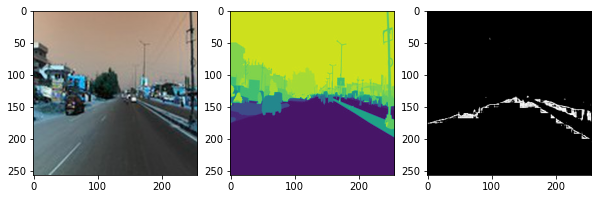

data/output/327/frame1124_gtFine_polygons.png


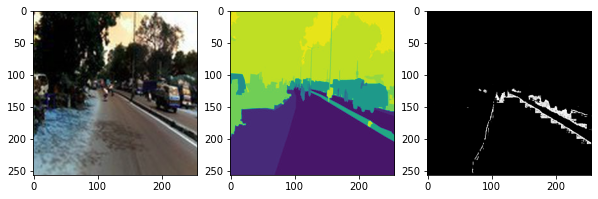

data/output/400/frame0595_gtFine_polygons.png


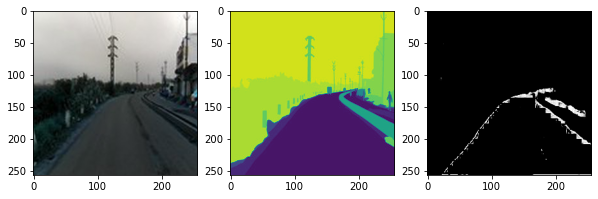

data/output/361/frame8692_gtFine_polygons.png


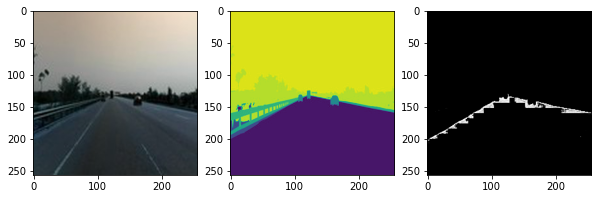

data/output/357/frame27932_gtFine_polygons.png


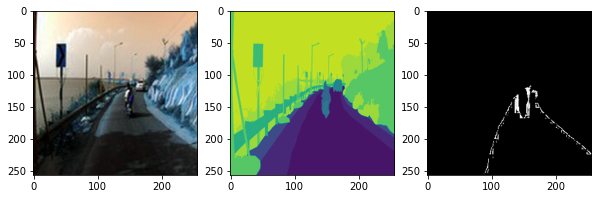

data/output/263/frame19513_gtFine_polygons.png


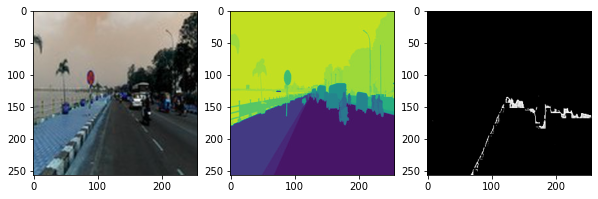

data/output/233/frame1002_gtFine_polygons.png


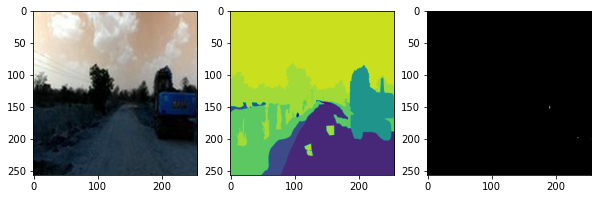

data/output/213/frame18369_gtFine_polygons.png


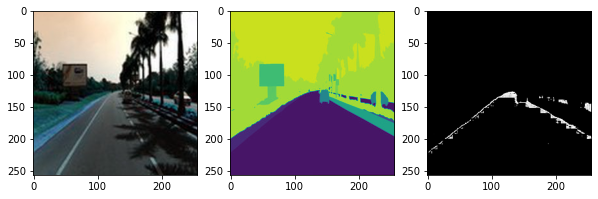

data/output/377/frame15853_gtFine_polygons.png


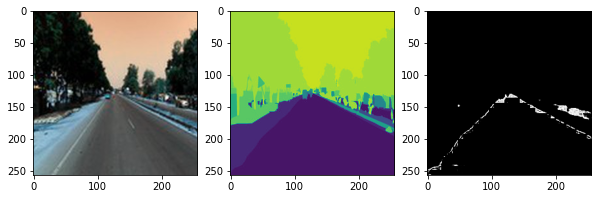

data/output/387/frame5281_gtFine_polygons.png


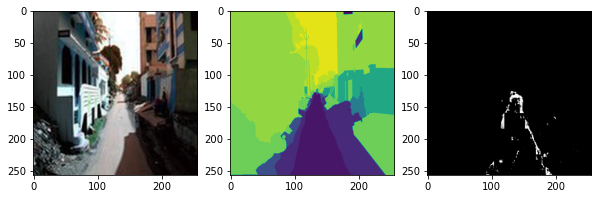

In [47]:
for i,m in zip(X_test[:10],y_test[:10]):
    #original image
    image = cv2.imread(i, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256)) 
    
    #predicted segmentation map
    predicted  = model.predict(image[np.newaxis,:,:,:])
    
    #original segmentation map
    image_mask = cv2.imread(m, cv2.IMREAD_UNCHANGED)
    print(m)
    image_mask = cv2.resize(image_mask, (256,256))

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(predicted[0,:,:,0], cmap='gray', vmax=1, vmin=0)
    plt.show()

# Task 3: Training CANet

In [11]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        self.conv1 = Conv2D(self.F1, (1, 1), strides = (1,1),kernel_initializer='glorot_uniform',activation='relu')
        self.bn1 = BatchNormalization()
        self.act1 = Activation('relu')

        self.conv2 = Conv2D(self.F2, (self.kernel,self.kernel), strides = (self.stride,self.stride), padding = 'same',kernel_initializer='glorot_uniform',activation='relu')
        self.bn2 = BatchNormalization()
        self.act2 = Activation('relu')

        self.conv3 = Conv2D(self.F3, (1, 1), strides = (1,1),kernel_initializer='glorot_uniform',activation='relu')
        self.bn3 = BatchNormalization()
        self.act3 = Activation('relu')

        self.conv4 = Conv2D(self.F3, (1,1), strides = (self.stride,self.stride),kernel_initializer='glorot_uniform',activation='relu')
        self.bn4 = BatchNormalization()
        self.add = Add()
        self.act4 = Activation('relu')
    def call(self, X):
        # copy of input to use later
        X_second = tf.identity(X)

        X = self.conv1(X)
        X = self.bn1(X)
        X = self.act1(X)

        X = self.conv2(X)
        X = self.bn2(X)
        X = self.act2(X)


        X = self.conv3(X)
        X = self.bn3(X)
        X = self.act3(X)

        #Other path
        X_second = self.conv4(X_second)
        X_second = self.bn4(X_second)
        X = self.add([X, X_second])
        X = self.act4(X)
        return X

In [12]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity_block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.conv1 = Conv2D(self.F1, (1, 1), strides = (1,1),kernel_initializer='he_uniform',activation='relu')
        self.bn1 = BatchNormalization()
        self.act1 =  Activation('relu')
        self.conv2 = Conv2D(self.F2, (self.kernel, self.kernel), strides = (1,1), padding = 'same',kernel_initializer='glorot_uniform',activation='relu')
        self.bn2 = BatchNormalization()
        self.act2 =  Activation('relu')
        self.conv3 = Conv2D(self.F3, (self.kernel, self.kernel), strides = (1,1),padding = 'same',kernel_initializer='glorot_uniform',activation='relu')
        self.bn3 = BatchNormalization()
        self.act3 =  Activation('relu')
        self.add = Add()
        self.act4 =  Activation('relu')

    def call(self, X):
        # copy of input to use later
        X_second = tf.identity(X)
    
        X = self.conv1(X)
        X = self.bn1(X)
        X = self.act1(X)

        X = self.conv2(X)
        X = self.bn2(X)
        X = self.act2(X)

        X = self.conv3(X)
        X = self.bn3(X)
        X = self.act3(X)

        X = self.add([X, X_second])
        X = self.act4(X)
        return X

In [13]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        self.pool = GlobalAveragePooling2D()
        self.reshape = tf.keras.layers.Reshape((1,1,64))
        self.bn = BatchNormalization()
        self.act = Activation('relu')
        self.conv = Conv2D(32, (1, 1), activation = 'relu', padding = 'same',name='conv_before_transpose',kernel_initializer='glorot_uniform')
        self.upsample = UpSampling2D(size=(32, 32), interpolation='bilinear')
    def call(self, X):
        X = self.pool(X)
        X = self.reshape(X)
        X = self.bn(X)
        X = self.act(X)
        X = self.conv(X)
        X = self.upsample(X)
        return X

In [14]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
        self.conc = Concatenate(axis=-1)
        self.avg_pool = AveragePooling2D((2, 2), (2, 2))
        self.conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same',kernel_initializer='glorot_uniform')
        self.conv2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same',kernel_initializer='glorot_uniform')
        self.conv3 = Conv2D(32, (1, 1), activation = 'relu', padding = 'same',kernel_initializer='glorot_uniform')
        self.act1 = Activation('relu')
        self.conv4 = Conv2D(32, (1, 1), activation = 'relu', padding = 'same',kernel_initializer='glorot_uniform')
        self.act2 =  Activation('sigmoid')
        self.mul = Multiply()
        self.add = Add()
        self.upsample = UpSampling2D(size=(2, 2), interpolation='bilinear')
    def call(self, X):
        INP, FLOW = X[0], X[1]

        X = self.conc([INP,FLOW])
        X = self.avg_pool(X)
        X = self.conv1(X)
        X = self.conv2(X)
        Conv1 = self.conv3(X)
        rel = self.act1(Conv1)
        Conv2 = self.conv4(rel)
        sig =  self.act2(Conv2)
        X_2 = self.mul([X , sig])
        X = self.add([X,X_2])
        X = self.upsample(X)
        return X

In [15]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        self.conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same',name='fs_conv_1',kernel_initializer='glorot_uniform')
        self.global_pool = GlobalAveragePooling2D(name='global_pool')
        self.reshape = tf.keras.layers.Reshape((1,1,32))
        self.conv2 = Conv2D(32, (1, 1), activation = 'relu', padding = 'same',name='fs_conv_2',kernel_initializer='glorot_uniform')
        self.bn = BatchNormalization()
        self.act = Activation('sigmoid')
        self.mul = Multiply(name='fs_mul')
        self.upsample = UpSampling2D(size=(2, 2), interpolation='bilinear')
    def call(self, X):
        Conv_1 = self.conv1(X)
        X = self.global_pool(Conv_1)
        X = self.reshape(X)
        X = self.conv2(X)
        X = self.bn(X)
        X = self.act(X)
        X = self.mul([Conv_1,X])
        X = self.upsample(X)
        return X

In [16]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)
        self.conv1 = Conv2D(32, (7, 1), activation = 'relu', padding = 'same')
        self.conv2 = Conv2D(32, (1, 7), activation = 'relu', padding = 'same')

        self.conv3 = Conv2D(32, (1, 7), activation = 'relu', padding = 'same')
        self.conv4 = Conv2D(32, (7, 1), activation = 'relu', padding = 'same')

        self.add = Add()

        self.conv5 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')

        self.out = Add()
        
    def call(self, X):
        Conv1 = self.conv1(X)
        Conv1 = self.conv2(Conv1)

        Conv2 = self.conv3(X)
        Conv2 = self.conv4(Conv2)

        O1 = self.add([Conv1,Conv2])

        Conv3 = self.conv5(O1)

        output = self.out([O1,Conv3])
        return output
# he uniform, different optim,

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, 
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-5 )

In [19]:
#new architecture
inp = Input((256,256,3))
X = Conv2D(64,(1,1),activation='relu')(inp)
X = BatchNormalization(momentum=0.9, epsilon=0.1)(X)
X = Activation('relu')(X)
X = MaxPooling2D()(X)
# C1
Conv_block = convolutional_block(kernel=3, filters=[4, 4, 8], stride=2,name='first_conv_block')
C1 = Conv_block(X)
identity = identity_block(3, [4, 4, 8], name='first_identity')
X = identity(C1)

# C2
Conv_block = convolutional_block(kernel=3, filters=[8, 8, 16], stride=2,name='second_conv_block')
C2 = Conv_block(X)
identity = identity_block(3, [8, 8, 16], name='second_identity_a')
X = identity(C2)
identity = identity_block(3, [8, 8, 16], name='second_identity_b')
X = identity(X)

# C3
Conv_block = convolutional_block(kernel=3, filters=[16, 16, 32], stride=1,name='third_conv_block')
C3 = Conv_block(X)
identity = identity_block(3, [16, 16, 32], name='third_identity_a')
X = identity(C3)
identity = identity_block(3, [16, 16, 32], name='third_identity_b')
X = identity(X)
identity = identity_block(3, [16, 16, 32], name='third_identity_c')
X = identity(X)

# C4
Conv_block = convolutional_block(kernel=3, filters=[32, 32, 64], stride=1,name='fourth_conv_block')
C4 = Conv_block(X)
identity = identity_block(3, [32, 32, 64], name='fourth_identity_a')
X = identity(C4)
identity = identity_block(3, [32, 32, 64], name='fourth_identity_b')
X = identity(X)
identity = identity_block(3, [32, 32, 64], name='fourth_identity_c')
X = identity(X)
identity = identity_block(3, [32, 32, 64], name='fourth_identity_d')
X = identity(X)
GF = global_flow()
global_output = GF(X)

CF = context_flow(name='context_flow_1')

CF_1 = CF([X,global_output])
CF = context_flow(name='context_flow_2')
CF_2 = CF([X,CF_1])
CF = context_flow(name='context_flow_3')
CF_3 = CF([X,CF_2])

cf_out = Add(name = 'add_cf_gf')([global_output, CF_1, CF_2, CF_3])

FSM = fsm()
fs_out = FSM(cf_out)
AGCN = agcn()
ag_out = AGCN(C1)
out = concatenate([fs_out,ag_out],axis=-1)

final = Conv2D(21, (3, 3), activation = 'relu', padding = 'same', name = 'final_conv')(out)

final_upsample = UpSampling2D(size=(4, 4), interpolation='bilinear')(final)

output = (Activation('softmax'))(final_upsample)
model = Model(inputs = inp, outputs = output)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 256, 256, 64) 256         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 256, 256, 64) 256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 256, 256, 64) 0           batch_normalization_15[0][0]     
_______________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [18]:
# model.load_weights('segmentation_final.h5')

In [19]:
optim = tf.keras.optimizers.RMSprop(learning_rate=1e-4)

focal_loss = sm.losses.cce_dice_loss

model.compile(optim, focal_loss, metrics=[iou_score])

In [20]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./my_model/best_canet_model.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, 
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-5 ),
]

In [21]:

history_CANet = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=300,\
                              validation_data=test_dataloader,callbacks=callbacks )

C:\Users\divya\anaconda3\envs\gpu_test\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/300
1603/1603 [==============================] - 505s 315ms/step - loss: 0.9356 - iou_score: 0.1006 - val_loss: 0.9219 - val_iou_score: 0.1107
Epoch 2/300
1603/1603 [==============================] - 507s 316ms/step - loss: 0.8992 - iou_score: 0.1240 - val_loss: 0.9032 - val_iou_score: 0.1273
Epoch 3/300
1603/1603 [==============================] - 506s 316ms/step - loss: 0.8870 - iou_score: 0.1324 - val_loss: 0.9018 - val_iou_score: 0.1330
Epoch 4/300
1603/1603 [==============================] - 505s 315ms/step - loss: 0.8784 - iou_score: 0.1381 - val_loss: 0.8839 - val_iou_score: 0.1403
Epoch 5/300
1603/1603 [==============================] - 505s 315ms/step - loss: 0.8738 - iou_score: 0.1409 - val_loss: 0.8822 - val_iou_score: 0.1380
Epoch 6/300
1603/1603 [==============================] - ETA: 0s - loss: 0.8706 - iou_score: 0.1429
Epoch 00006: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
1603/1603 [==============================] - 506s 316ms/step - lo

1603/1603 [==============================] - 481s 300ms/step - loss: 0.8211 - iou_score: 0.1779 - val_loss: 0.9844 - val_iou_score: 0.1305
Epoch 97/300
1603/1603 [==============================] - 485s 303ms/step - loss: 0.8211 - iou_score: 0.1781 - val_loss: 0.9694 - val_iou_score: 0.1338
Epoch 98/300
1603/1603 [==============================] - 481s 300ms/step - loss: 0.8209 - iou_score: 0.1781 - val_loss: 0.9837 - val_iou_score: 0.1290
Epoch 99/300
1603/1603 [==============================] - 479s 299ms/step - loss: 0.8206 - iou_score: 0.1783 - val_loss: 0.9561 - val_iou_score: 0.1348
Epoch 100/300
1603/1603 [==============================] - 480s 299ms/step - loss: 0.8205 - iou_score: 0.1783 - val_loss: 0.9802 - val_iou_score: 0.1313
Epoch 101/300
1603/1603 [==============================] - 480s 299ms/step - loss: 0.8205 - iou_score: 0.1785 - val_loss: 0.9805 - val_iou_score: 0.1298
Epoch 102/300
1603/1603 [==============================] - 481s 300ms/step - loss: 0.8205 - iou_sco

1603/1603 [==============================] - 485s 302ms/step - loss: 0.8062 - iou_score: 0.1893 - val_loss: 1.0336 - val_iou_score: 0.1131
Epoch 203/300
1603/1603 [==============================] - 484s 302ms/step - loss: 0.8058 - iou_score: 0.1896 - val_loss: 1.0173 - val_iou_score: 0.1191
Epoch 204/300
1603/1603 [==============================] - 485s 303ms/step - loss: 0.8060 - iou_score: 0.1895 - val_loss: 1.0266 - val_iou_score: 0.1155
Epoch 205/300
1603/1603 [==============================] - 485s 303ms/step - loss: 0.8055 - iou_score: 0.1899 - val_loss: 1.0338 - val_iou_score: 0.1147
Epoch 206/300
1603/1603 [==============================] - 485s 303ms/step - loss: 0.8054 - iou_score: 0.1900 - val_loss: 1.0139 - val_iou_score: 0.1186
Epoch 207/300
1603/1603 [==============================] - 485s 303ms/step - loss: 0.8053 - iou_score: 0.1901 - val_loss: 1.0272 - val_iou_score: 0.1180
Epoch 208/300
1603/1603 [==============================] - 485s 303ms/step - loss: 0.8052 - iou_

In [23]:
history_CANet.history

{'loss': [0.93559330701828,
  0.8991687893867493,
  0.8870009779930115,
  0.878387987613678,
  0.873794674873352,
  0.8705824613571167,
  0.8669613599777222,
  0.8649089336395264,
  0.8615716099739075,
  0.8598193526268005,
  0.8580127954483032,
  0.856942892074585,
  0.8548129200935364,
  0.8531715273857117,
  0.8520188927650452,
  0.8513617515563965,
  0.8500034809112549,
  0.8498353362083435,
  0.849118173122406,
  0.8480204939842224,
  0.846939206123352,
  0.8460758328437805,
  0.844744086265564,
  0.8434590101242065,
  0.8423703908920288,
  0.8418986797332764,
  0.8416497707366943,
  0.8404574990272522,
  0.8400893211364746,
  0.8395587205886841,
  0.8383551239967346,
  0.837592363357544,
  0.8371618390083313,
  0.8368680477142334,
  0.836155354976654,
  0.8357716202735901,
  0.8346185088157654,
  0.8345476388931274,
  0.8340548276901245,
  0.8342217206954956,
  0.8342010974884033,
  0.8336811661720276,
  0.8327571749687195,
  0.8321670889854431,
  0.8322188258171082,
  0.83187651

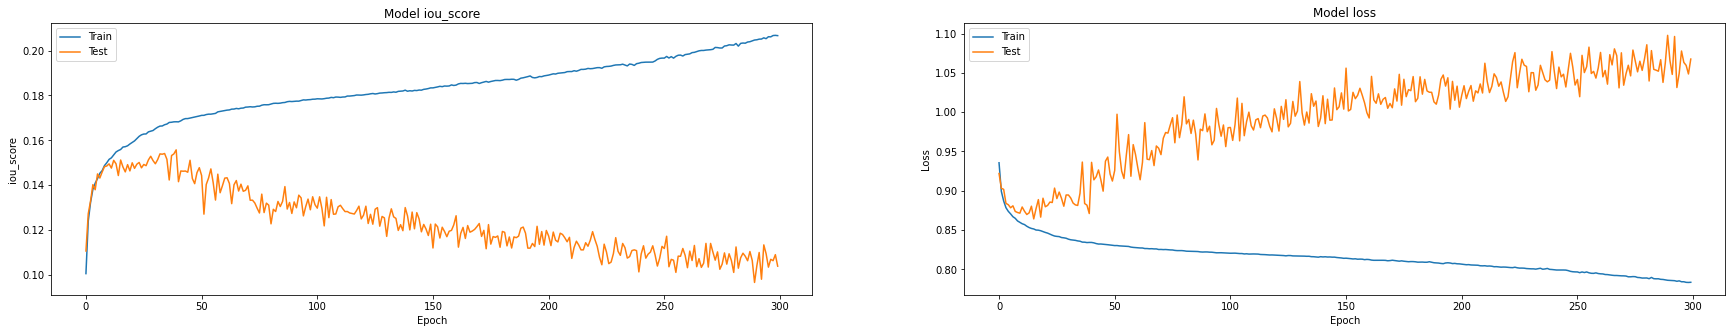

In [24]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history_CANet.history['iou_score'])
plt.plot(history_CANet.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history_CANet.history['loss'])
plt.plot(history_CANet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 47ms/step


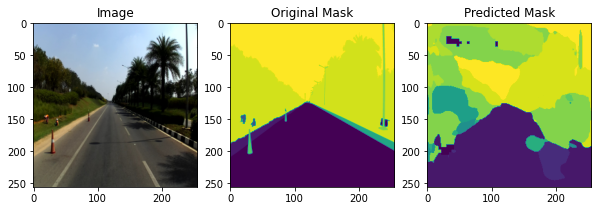

1/1 [==============================] - 0s 44ms/step


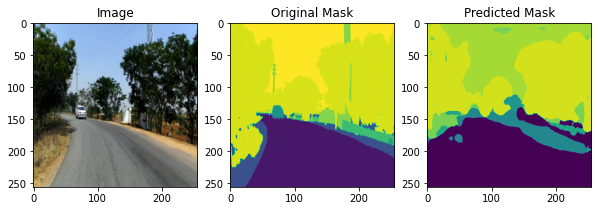

1/1 [==============================] - 0s 42ms/step


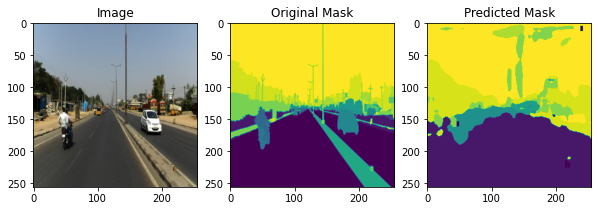

1/1 [==============================] - 0s 34ms/step


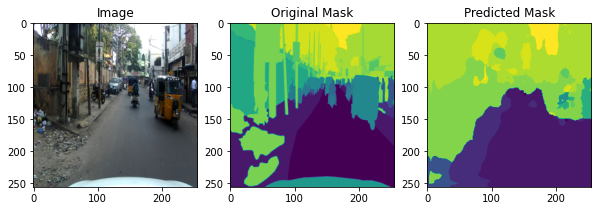

1/1 [==============================] - 0s 30ms/step


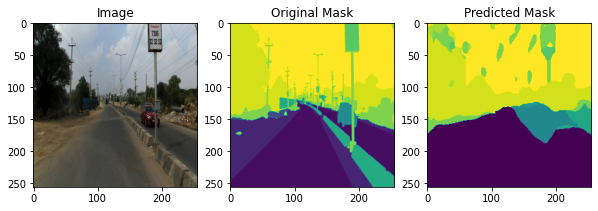

1/1 [==============================] - 0s 54ms/step


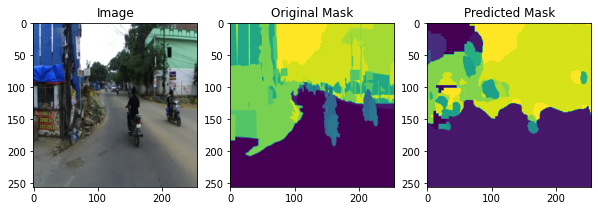

1/1 [==============================] - 0s 45ms/step


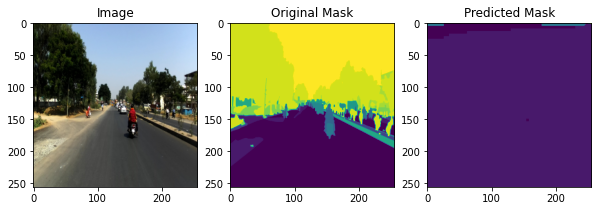

1/1 [==============================] - 0s 43ms/step


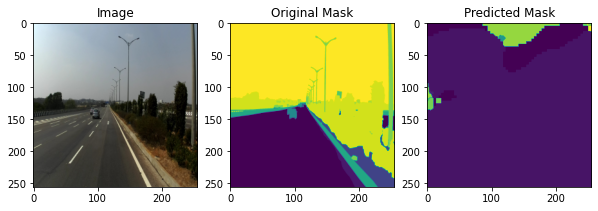

1/1 [==============================] - 0s 37ms/step


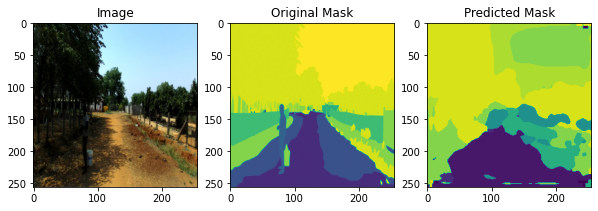

1/1 [==============================] - 0s 41ms/step


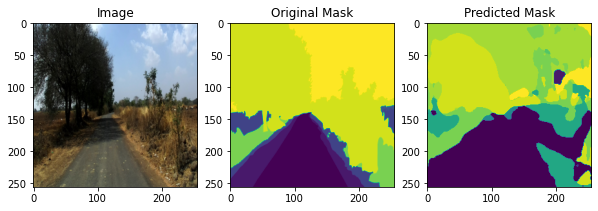

1/1 [==============================] - 0s 48ms/step


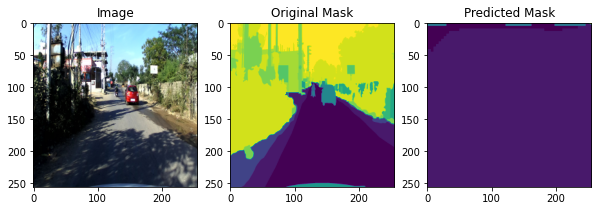

1/1 [==============================] - 0s 26ms/step


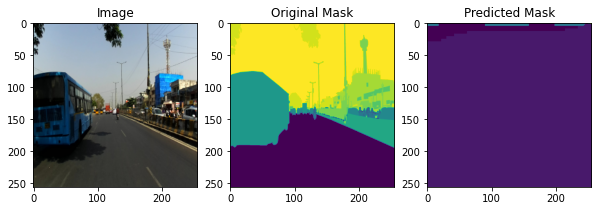

1/1 [==============================] - 0s 30ms/step


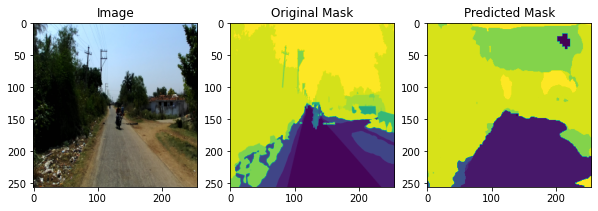

1/1 [==============================] - 0s 32ms/step


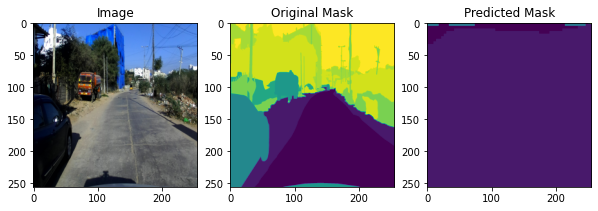

1/1 [==============================] - 0s 35ms/step


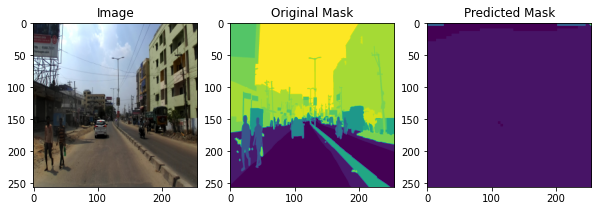

In [29]:
images_ = test_df['image'].values
masks_ = test_df['mask'].values
lst = np.arange(len(images_))
import random
ids = np.random.choice(lst, size = 15, replace = False)
for i in ids:
  image = cv2.imread(images_[i], cv2.IMREAD_UNCHANGED)
  image = cv2.resize(image, (256, 256),  interpolation = cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = np.expand_dims(image, axis=0)

  mask  = cv2.imread(masks_[i], cv2.IMREAD_UNCHANGED)
  mask = cv2.resize(mask, (256, 256),  interpolation = cv2.INTER_AREA)
  mask = mask / 10
  pred = model.predict(image,verbose=1)
  pred = tf.argmax(pred, axis=-1)

  fig = plt.figure(figsize=(10,6))
  #plt.figure(figsize=(10,6))
  ax1 = fig.add_subplot(131)
  ax1.imshow(image[0,:,:])
  ax2=fig.add_subplot(132)
  ax2.imshow(mask)
  ax3=fig.add_subplot(133)
  ax3.imshow(pred[0,:,:])
  ax1.title.set_text('Image')
  ax2.title.set_text('Original Mask')
  ax3.title.set_text('Predicted Mask')
  plt.show()